In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pickle

In [0]:
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

train_data = datasets.MNIST(root='data',transform=transforms, download=True)

In [0]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

In [0]:
images, labels = next(iter(train_data_loader))

In [0]:
images.shape


torch.Size([32, 1, 28, 28])

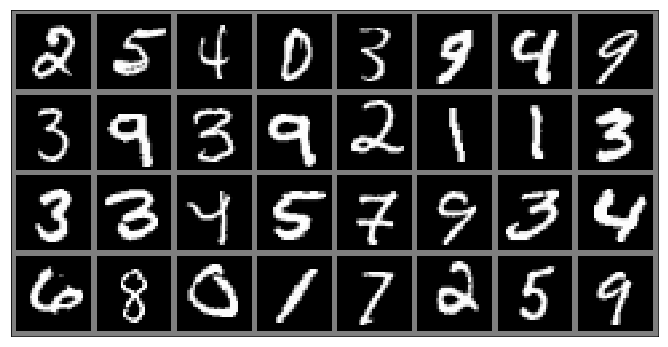

In [0]:
def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(30, 6))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show
    
image_display(torchvision.utils.make_grid(images))

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda', index=0)

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        latent_space_size = 100
        
        number_output = 28*28
        
        self.first_hidden_layer = nn.Sequential(nn.Linear(latent_space_size, 256),
                                                nn.LeakyReLU(0.2))
        
        self.second_hidden_layer = nn.Sequential(nn.Linear(256, 512),
                                                 nn.LeakyReLU(0.2))
        
        self.third_hidden_layer = nn.Sequential(nn.Linear(512, 1024),
                                                nn.LeakyReLU(0.2))
        
        self.output_layer = nn.Sequential(nn.Linear(1024, number_output),
                                         nn.Tanh())
        
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)

        x = self.first_hidden_layer(x)   
        
        x = self.second_hidden_layer(x)
        
        x = self.third_hidden_layer(x)
        
        generator_output = self.output_layer(x)
        
        return generator_output

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        num_classes = 1        
        
        size_of_flatten_input = 28*28
        
        drop_out_percentage = 0.3
        
        super(Discriminator, self).__init__()
        
        self.first_hidden_layer = nn.Sequential(nn.Linear(size_of_flatten_input, 1024),
                                                nn.LeakyReLU(0.2),
                                                nn.Dropout(p=drop_out_percentage))
        
        self.second_hidden_layer = nn.Sequential(nn.Linear(1024, 512),
                                                nn.LeakyReLU(0.2),
                                                nn.Dropout(p=drop_out_percentage))
        
        self.third_hidden_layer = nn.Sequential(nn.Linear(512, 256),
                                                nn.LeakyReLU(0.2),
                                                nn.Dropout(p=drop_out_percentage))
        
        self.output_layer = nn.Sequential(nn.Linear(256, 1))
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)
        
        x = self.first_hidden_layer(x)   
        
        x = self.second_hidden_layer(x)
        
        x = self.third_hidden_layer(x)
        
        discriminator_output = self.output_layer(x)
        
        return discriminator_output
        
        
    

In [0]:
G = Generator().to(device)
D = Discriminator().to(device)

In [0]:
D

Discriminator(
  (first_hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (second_hidden_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (third_hidden_layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [0]:
G

Generator(
  (first_hidden_layer): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (second_hidden_layer): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (third_hidden_layer): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [0]:
learning_rate = 0.0002
optimizer_generator = torch.optim.Adam(G.parameters(), lr=learning_rate)
optimizer_discriminator = torch.optim.Adam(D.parameters(), lr=learning_rate)
criteria = nn.BCEWithLogitsLoss()

In [0]:
def real_loss(discriminator_output):
    
    true_target = torch.ones(discriminator_output.size(0), 1).to(device)
    loss = criteria(discriminator_output, true_target)
    
    return loss
    
    
    
def fake_loss(discriminator_output):
    
    true_target = torch.zeros(discriminator_output.size(0), 1).to(device)
    loss = criteria(discriminator_output, true_target)
    
    return loss

# def real_loss(D_out, smooth=False):
#     batch_size = D_out.size(0)
#     # label smoothing
#     if smooth:
#         # smooth, real labels = 0.9
#         labels = torch.ones(batch_size)*0.9
#     else:
#         labels = torch.ones(batch_size).to(device) # real labels = 1
        
#     # numerically stable loss
#     criterion = nn.BCEWithLogitsLoss()
#     # calculate loss
#     loss = criterion(D_out.squeeze(), labels)
#     return loss

# def fake_loss(D_out):
#     batch_size = D_out.size(0)
#     labels = torch.zeros(batch_size).to(device) # fake labels = 0
#     criterion = nn.BCEWithLogitsLoss()
#     # calculate loss
#     loss = criterion(D_out.squeeze(), labels)
#     return loss

In [0]:
def latent_vector_creator():
    random_numbers = np.random.uniform(-1, 1, size=(train_data_loader.batch_size, 100))
    return torch.from_numpy(random_numbers).float().to(device)

In [0]:
def test_latent_vector(numbers_of_samples):
    random_numbers = np.random.uniform(-1, 1, size=(numbers_of_samples, 100))
    return torch.from_numpy(random_numbers).float().to(device)

In [0]:
number_of_epoch = 1000
discriminator_loss_array = []
generator_loss_array = []
generated_images_array = []

for i in range(number_of_epoch):
    
    total_discriminator_loss = 0
    total_generator_loss = 0
    
#   setting the network to training mode
    D.train()
    G.train()
    
    for real_images, _ in train_data_loader:
        
#       set the image values to be betwwen -1 and 1
        real_images = real_images*2 - 1
        
        real_images = real_images.to(device)
        
#       Generator training code
        optimizer_generator.zero_grad()
    
#       The code below helps to get the generator loss
        outputs_from_generator = G(latent_vector_creator())
        
        generator_logit = D(outputs_from_generator)
          
#       The generator loss
        generator_loss = real_loss(generator_logit)
        
        generator_loss.backward()
        
        optimizer_generator.step()
        
        total_generator_loss += generator_loss.item() * train_data_loader.batch_size
#         
#         
#                    
#       Discriminator training code
        optimizer_discriminator.zero_grad()

#       The code below help to get the discriminator real loss  
        discriminator_real_image_logit = D(real_images)
        
        discriminator_real_loss = real_loss(discriminator_real_image_logit)
         
#       The code below helps to get the discriminator fake loss
        fake_outputs_from_generator = G(latent_vector_creator())
        
        discriminator_fake_image_logit = D(fake_outputs_from_generator)
        
        discriminator_fake_loss = fake_loss(discriminator_real_image_logit)
        
#       The discriminator loss
        discriminator_loss = discriminator_real_loss + discriminator_fake_loss
        
        discriminator_loss.backward()
        
        optimizer_discriminator.step()
        
        total_discriminator_loss += discriminator_loss.item() * train_data_loader.batch_size
#       End of discriminator training code
    
#   This computes the total discriminator loss and also append it to an array
    total_discriminator_loss_per_epoch = round(total_discriminator_loss/len(train_data_loader.dataset), 5)
    discriminator_loss_array.append(total_discriminator_loss_per_epoch)
    
#   This computes the total generators loss and also append it to an array
    total_generator_loss_per_epoch = round(total_generator_loss/len(train_data_loader.dataset), 5)
    generator_loss_array.append(total_generator_loss_per_epoch)
    
#   print training results
    print(f'{i+1}/{number_of_epoch} The generator loss: {total_generator_loss_per_epoch}... The discriminator loss: {total_discriminator_loss_per_epoch}')
#     
#     
#     
#   Here we will use the Generator to create fake images after each epoch to see it's performance 
    G.eval()
    generated_samples = G(test_latent_vector(16))
    generated_images_array.append(generated_samples)
#     
#     
#    
#   Here will dump the generated_images_array into a pickle
with open('image_generated.pkl', 'wb') as f:
    pickle.dump(generated_images_array, f)

1/32 The generator loss: 0.6913... The discriminator loss: 1.38629
2/32 The generator loss: 0.69291... The discriminator loss: 1.38629


KeyboardInterrupt: ignored

Text(0, 0.5, 'Generator_Loss and discriminator_loss')

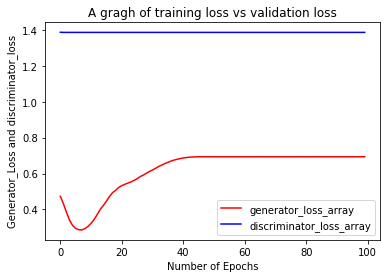

In [0]:
x_axis = (range(number_of_epoch))

plt.plot(x_axis, generator_loss_array, 'r', discriminator_loss_array, 'b')

plt.title('A gragh of training loss vs validation loss')

plt.legend(['generator_loss_array', 'discriminator_loss_array'])

plt.xlabel('Number of Epochs')

plt.ylabel('Generator_Loss and discriminator_loss')

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
with open('image_generated.pkl', 'rb') as f:
    generated_samples = pickle.load(f)

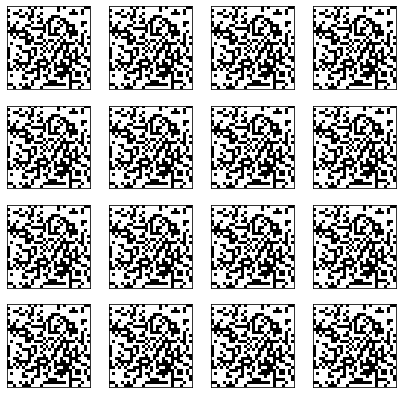

In [0]:
view_samples(-1, generated_samples)

In [0]:
generated_samples

[tensor([[-1., -1., -1.,  ..., -1.,  1.,  1.],
         [ 1., -1.,  1.,  ...,  1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [-1.,  1.,  1.,  ..., -1.,  1., -1.]], device='cuda:0',
        requires_grad=True), tensor([[-1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [ 1., -1.,  1.,  ...,  1., -1., -1.],
         [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [ 1.,  1.,  1.,  ..., -1.,  1.,  1.]], device='cuda:0',
        requires_grad=True), tensor([[-1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [ 1., -1.,  1.,  ...,  1., -1., -1.]], device='cuda:0',
  